<a href="https://colab.research.google.com/github/abhishekanand1710/csml-cs567-assignments/blob/main/assignment-1/CSML_Assignment_1_Notebook_1_CIFAR_using_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dependencies
!pip install seaborn
!pip install torch
!pip install torchvision

In [2]:
import seaborn as sns
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split

In [3]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def get_cifar10_dataset(train):
  return torchvision.datasets.CIFAR10(root='./data', train=train, download=True, transform=transform)

In [4]:
dataset = get_cifar10_dataset(train = True)
test_set = get_cifar10_dataset(train = False)

100%|██████████| 170498071/170498071 [00:13<00:00, 12364986.83it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


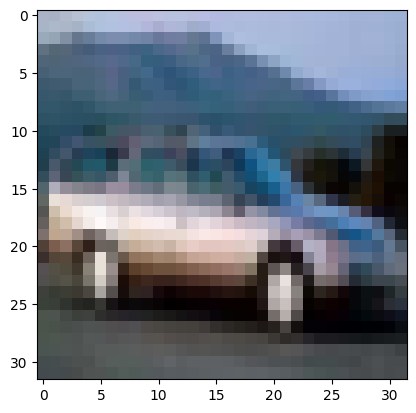

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(dataset[4][0])

In [6]:
dataset[4][0].size()

torch.Size([3, 32, 32])

In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
class_count = {}
for _, index in dataset:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
class_count

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'car': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'plane': 5000}

In [9]:
SEED = 875
torch.manual_seed(SEED)
VAL_SIZE = 5000
TRAIN_SIZE = len(dataset) - VAL_SIZE
BATCH_SIZE = 32

In [10]:
train_set, val_set = random_split(dataset, [TRAIN_SIZE, VAL_SIZE])
len(train_set), len(val_set)

(45000, 5000)

In [11]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
# Let's initialize our model
N_CLASSES = 10

class MLP(torch.nn.Module):
  def __init__(self):
    super().__init__()
    # Could use Sequential
    self.layer_1 = torch.nn.Linear(32*32*3, 256)
    self.layer_2 = torch.nn.Linear(256, 128)
    self.layer_3 = torch.nn.Linear(128, N_CLASSES)

  def forward(self, x):
    x = x.view(-1, 32*32*3)
    x = torch.nn.functional.relu(self.layer_1(x))
    x = torch.nn.functional.relu(self.layer_2(x))
    return self.layer_3(x)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ', device.type)

Device:  cuda


In [14]:
# Model
model = MLP()
model.to(device)

MLP(
  (layer_1): Linear(in_features=3072, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=10, bias=True)
)

In [15]:
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
LEARNING_RATE = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [16]:
# Time to train
NUM_EPOCHS = 10

trn_accs = []
val_accs = []
trn_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    running_correct = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_correct += torch.sum(torch.argmax(outputs, dim=-1) == labels).item()

    # Validate
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for batch in val_loader:
          inputs, labels = batch
          inputs = inputs.cuda()
          labels = labels.cuda()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          val_running_loss += loss.item()
          val_running_correct += torch.sum(torch.argmax(outputs, dim=-1) == labels).item()

    print(f"Epoch: {epoch+1}/{NUM_EPOCHS}", end=" ")

    avg_trn_loss = running_loss / len(train_loader)
    avg_val_loss = val_running_loss / len(val_loader)
    trn_losses.append(avg_trn_loss)
    val_losses.append(avg_val_loss)

    trn_acc = running_correct / len(train_set)
    val_acc = val_running_correct / len(val_set)
    trn_accs.append(trn_acc)
    val_accs.append(val_acc)

    print(f"Loss: {round(avg_trn_loss, 4)} ({round(avg_val_loss, 4)})", end=" ")  # Avg. per batch
    print(f"Accuracy: {round(trn_acc, 2)} ({round(val_acc, 2)})")

print("Finished Training")

Epoch: 1/10 Loss: 1.6616 (1.5476) Accuracy: 0.41 (0.45)
Epoch: 2/10 Loss: 1.4674 (1.4781) Accuracy: 0.48 (0.48)
Epoch: 3/10 Loss: 1.3622 (1.4541) Accuracy: 0.52 (0.49)
Epoch: 4/10 Loss: 1.2799 (1.4159) Accuracy: 0.54 (0.51)
Epoch: 5/10 Loss: 1.2105 (1.4559) Accuracy: 0.57 (0.5)
Epoch: 6/10 Loss: 1.1466 (1.4208) Accuracy: 0.6 (0.52)
Epoch: 7/10 Loss: 1.0859 (1.4814) Accuracy: 0.62 (0.51)
Epoch: 8/10 Loss: 1.0302 (1.4444) Accuracy: 0.63 (0.53)
Epoch: 9/10 Loss: 0.978 (1.4945) Accuracy: 0.65 (0.52)
Epoch: 10/10 Loss: 0.9246 (1.5343) Accuracy: 0.67 (0.53)
Finished Training


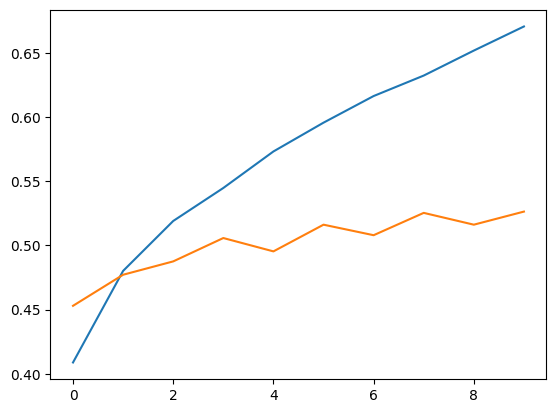

In [17]:
# Let's check out losses and accuracies
plt.plot(range(NUM_EPOCHS), trn_accs)
plt.plot(range(NUM_EPOCHS), val_accs)
plt.show()

In [18]:
test_running_loss = 0.0
test_running_correct = 0

with torch.no_grad():
  for batch in test_loader:
    inputs, labels = batch
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    test_running_loss += loss.item()
    test_running_correct += torch.sum(torch.argmax(outputs, dim=-1) == labels).item()

avg_test_loss = test_running_loss / len(test_loader)
test_acc = test_running_correct / len(test_set)

print(f"Test loss: {avg_test_loss}, Test accuracy: {test_acc}")

Test loss: 1.5259059806601307, Test accuracy: 0.5189
